In [65]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import importlib

import inv_cdfs as icdf
import agents_network as anet

importlib.reload(icdf)
importlib.reload(anet)

<module 'agents_network' from '/home/dimitribouche/Bureau/MVA/S1/GML/Projet/WasserteinProp/agents_network.py'>

# Créer et utiliser un objet InvCdf (fonction de répartition inverse)

### Créer l'objet vide

In [30]:
# nsamples_icdf = nombre de points de discrétisation de l'intervalle [0, 1]
invcdf1 = icdf.InvCdf(nsamples_icdf=10000, density_type="continuous")

### Remplir l'objet
2 possibilités:
- Avec une distribution scipy
- Avec un dataset (on prend alors la distribution empirique)

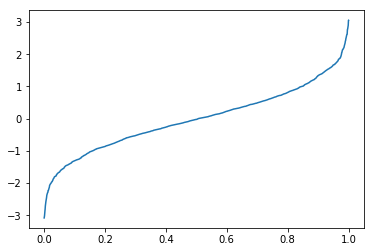

In [44]:
# Exemple avec un dataset suivant une loi normale
dataset = np.random.normal(0, 1, 2000)
invcdf1.fill_from_data(dataset)
plt.plot(invcdf1.qs, invcdf1.invcdf)
# invcdf1.qs est le vecteur de discrétisation de [0, 1]
# invcdf1.invcdf est le vecteur de valeur de la fonction de répartition inverse aux valeurs invcdf1.qs

### Inférer CDF et PDF

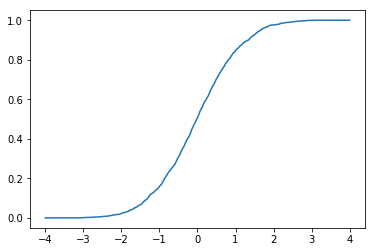

In [45]:
# Créer la CDF depuis la inv CDF
# Meme principe on discrétise l'intervalle [start, stop] avec nsamples_cdf points
invcdf1.fill_cdf(start=-4, stop=4, nsamples_cdf=10000)
plt.plot(invcdf1.ts, invcdf1.cdf)
# invcdf1.ts est le vecteur de discrétisation de [start, stop]
# invcdf1.cdf est le vecteur de valeur de la fonction de répartition aux valeurs invcdf1.ts

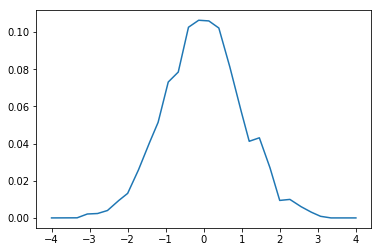

In [48]:
# Créer la densité (nécéssite d'avoir créé la CDF auparavant)
invcdf1.fill_rho_continuous(nbins=30)
# invcdf1 a ensuite un attribut rho qui est une fonction python de densité empirique
plt.plot(invcdf1.ts, [invcdf1.rho(t) for t in invcdf1.ts])
# plt.plot(invcdf1.rho[0], invcdf1.rho[1])

### Pareil dans le cas discret

In [66]:
# nsamples_icdf = nombre de points de discrétisation de l'intervalle [0, 1]
invcdf1 = icdf.InvCdf(nsamples_icdf=10000, density_type="discrete")

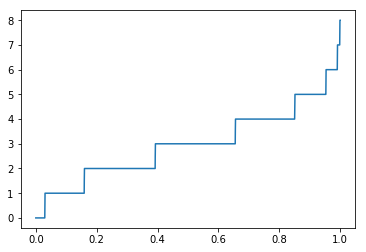

In [77]:
# Exemple avec un dataset suivant une loi normale
dataset = np.random.binomial(10, 0.3, 2000)
invcdf1.fill_from_data(dataset)
plt.plot(invcdf1.qs, invcdf1.invcdf)
# invcdf1.qs est le vecteur de discrétisation de [0, 1]
# invcdf1.invcdf est le vecteur de valeur de la fonction de répartition inverse aux valeurs invcdf1.qs

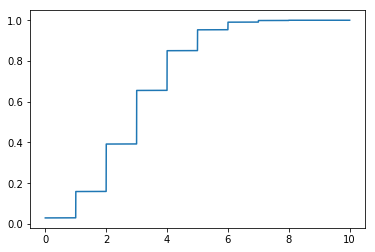

In [78]:
# Créer la CDF depuis la inv CDF
# Meme principe on discrétise l'intervalle [start, stop] avec nsamples_cdf points
invcdf1.fill_cdf(start=0, stop=10, nsamples_cdf=10000)
plt.plot(invcdf1.ts, invcdf1.cdf)
# invcdf1.ts est le vecteur de discrétisation de [start, stop]
# invcdf1.cdf est le vecteur de valeur de la fonction de répartition aux valeurs invcdf1.ts

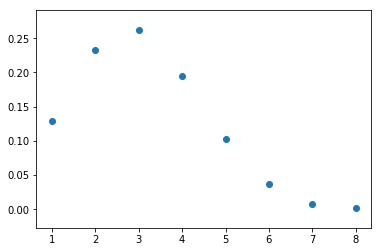

In [81]:
# Créer la densité (nécéssite d'avoir créé la CDF auparavant)
invcdf1.fill_rho_discrete(thresh=0.0002)
# invcdf1 a ensuite un attribut rho qui est un tuple : vecteur de valeurs, vecteur de probabilités
plt.scatter(invcdf1.rho[0], invcdf1.rho[1])
# plt.plot(invcdf1.rho[0], invcdf1.rho[1])

# Gossip algorithm

In [25]:
# Create empty InvCdf instances
invcdf1 = icdf.InvCdf(nsamples_icdf=10000)
invcdf2 = icdf.InvCdf(nsamples_icdf=10000)
invcdf3 = icdf.InvCdf(nsamples_icdf=10000)
invcdf4 = icdf.InvCdf(nsamples_icdf=10000)

Text(0.5, 1.0, 'Initial inverse cdfs')

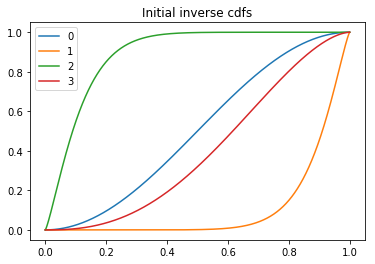

In [26]:
# Fill them with beta distributions
# IMPORTANT: Tu peux mettre n'importe quelle distribution scipy ou alors faire la version d'initialisation depuis un dataset
# Parameters for the beta distributions
a1, b1 = 0.5, 0.5
a2, b2 = 0.1, 0.8
a3, b3 = 0.8, 0.1
a4, b4 = 0.4, 0.6
# Instantiate the beta distributions (on utilise ici la version scipy de l'initialisation)
dist1 = stats.beta(a1, b1)
dist2 = stats.beta(a2, b2)
dist3 = stats.beta(a3, b3)
dist4 = stats.beta(a4, b4)
# Fill InvCdf instances with the beta distribution
invcdf1.fill_from_scipy(dist1)
invcdf2.fill_from_scipy(dist2)
invcdf3.fill_from_scipy(dist3)
invcdf4.fill_from_scipy(dist4)
# Plot invcdf of the distributions
plt.figure()
plt.plot(invcdf1.qs, invcdf1.invcdf, label=0)
plt.plot(invcdf1.qs, invcdf2.invcdf, label=1)
plt.plot(invcdf1.qs, invcdf3.invcdf, label=2)
plt.plot(invcdf1.qs, invcdf4.invcdf, label=3)
plt.legend()
plt.title("Initial inverse cdfs")

In [27]:
# Create agent network
# Number of agents in the network
npeers = 4
# Initialize agents with the beta distributions as solitary (initial) model
agent1 = anet.Agent(npeers, 0, invcdf1)
agent2 = anet.Agent(npeers, 1, invcdf2)
agent3 = anet.Agent(npeers, 2, invcdf3)
agent4 = anet.Agent(npeers, 3, invcdf4)
# Stack agents in a list
agents = [agent1, agent2, agent3, agent4]

In [28]:
# Initialize weight matrix (here we take a complete graph)
W = np.ones((npeers, npeers)) - np.eye(npeers)
# Confidence of 1 in every model
C = np.ones(npeers)

In [38]:
# Build network
network = anet.AgentNetwork(W, C, agents, mu=1)

In [39]:
# Run asynchronous gossip algorithm
network.iterate_async_gossip(100)
# Update finale model for each agents
network.update_invcdf_models()
# Une fois que cela est fait, pour chaque agent la seule chose qui nous interesse 
# Est l'attribut "invcdf_model" qui contient un objet InvCdf qui contient la fonction de répartition inverse
# de la distribution apprise par l'agent
# On les stocke dans une list
invcdfs = [network.agents[i].invcdf_model for i in range(0, npeers)]
# Fill the cdf from those models for each agent
for invcdf in invcdfs:
    invcdf.fill_cdf(start=0, stop=1, nsamples_cdf=10000)

Text(0.5, 1.0, 'Propagated inverse cdfs')

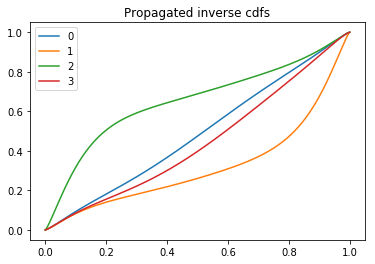

In [40]:
# Plot the results
plt.figure()
for i in range(0, npeers):
    plt.plot(invcdf1.qs, network.agents[i].models_matrix[:, i], label=i)
plt.legend()
plt.title("Propagated inverse cdfs")

Text(0.5, 1.0, 'Propagated cdfs')

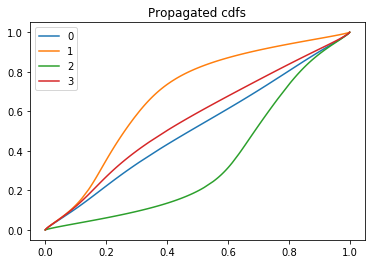

In [42]:
# Plot propagated cdfs
plt.figure()
for i in range(0, npeers):
    plt.plot(invcdfs[i].ts, invcdfs[i].cdf, label=i)
plt.legend()
plt.title("Propagated cdfs")